In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import keras
import tensorflow
import glob

%matplotlib inline

In [2]:
class_names = ['SUFFICIENT', 'INSUFFICIENT'] #identify classes of model

In [20]:
# get the reference to the webcam
camera = cv2.VideoCapture(0) # Access webcam from labtop
camera_height = 500
raw_frames_type_1 = []
raw_frames_type_2 = []
raw_frames_type_3 = []

while(True):
    # read a new frame
    _, frame = camera.read()
    
    # flip the frame
    frame = cv2.flip(frame, 1)
    
    # rescaling camera output
    aspect = frame.shape[1] / float(frame.shape[0])
    res = int(aspect * camera_height) # landscape orientation - wide image
    frame = cv2.resize(frame, (res, camera_height))
    
    # add rectangle
    cv2.rectangle(frame, (300, 75), (650, 425), (0, 255, 0), 2)
    
    # show the frame
    cv2.imshow("Capturing frames", frame)
    
    key = cv2.waitKey(1)
    
    # quit camera if 'q' key is pressed
    if key & 0xFF == ord('q'):
        break
    elif key & 0xFF == ord('1'):
        # save the frame
        raw_frames_type_1.append(frame)
        print('1 key pressed - saved TYPE_1 frame')
    elif key & 0xFF == ord('2'):
        raw_frames_type_2.append(frame)
        print('2 key pressed - saved TYPE_2 frame')
    elif key & 0xFF == ord('3'):
        raw_frames_type_3.append(frame)
        print('3 key pressed - saved TEST frame')
        
camera.release()
cv2.destroyAllWindows()

In [4]:
save_width = 399
save_height = 399

In [5]:
for i, frame in enumerate(raw_frames_type_1):
    roi = frame[75+2:425-2, 300+2:650-2]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, (save_width, save_height))
    cv2.imwrite('./data/images_type_1/{}.png'.format(i), cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    
for i, frame in enumerate(raw_frames_type_2):
    roi = frame[75+2:425-2, 300+2:650-2]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, (save_width, save_height))
    cv2.imwrite('./data/images_type_2/{}.png'.format(i), cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))

for i, frame in enumerate(raw_frames_type_3):
    roi = frame[75+2:425-2, 300+2:650-2]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, (save_width, save_height))
    cv2.imwrite('./data/images_test/{}.png'.format(i), cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))

In [6]:
width = 96
height = 96

In [19]:
from glob import glob
from keras import preprocessing

# load images type_1
images_type_1 = []
for image_path in glob('./data/images_type_1/*.*'):
    image = preprocessing.image.load_img(image_path, target_size = (width, height))
    
    x = preprocessing.image.img_to_array(image)
    
    images_type_1.append(x)

# load images type_2
images_type_2 = []
for image_path in glob('./data/images_type_2/*.*'):
    image = preprocessing.image.load_img(image_path, target_size = (width, height))
    
    x = preprocessing.image.img_to_array(image)
    
    images_type_2.append(x)
    
# load images TEST
images_test = []
for image_path in glob('./data/images_test/*.*'):
    image = preprocessing.image.load_img(image_path, target_size = (width, height))
    
    x = preprocessing.image.img_to_array(image)
    
    images_test.append(x)

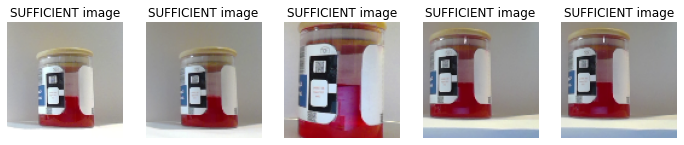

In [8]:
# check photos and show in notebook
plt.figure(figsize = (12,8))

for i, x in enumerate(images_type_1[:5]):
    plt.subplot(1, 5, i+1)
    image = preprocessing.image.array_to_img(x)
    plt.imshow(image)
    
    plt.axis('off')
    plt.title('{} image'.format(class_names[0]))
    
# show the plot
plt.show()

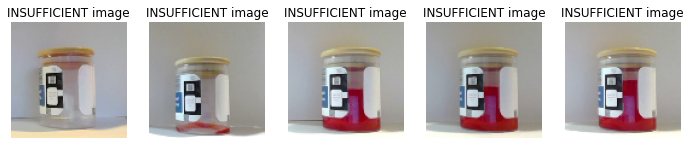

In [9]:
# check photos and show in notebook
plt.figure(figsize = (12,8))

for i, x in enumerate(images_type_2[:5]):
    plt.subplot(1, 5, i+1)
    image = preprocessing.image.array_to_img(x)
    plt.imshow(image)
    
    plt.axis('off')
    plt.title('{} image'.format(class_names[1]))
    
# show the plot
plt.show()

In [10]:
# prepare images as tensors
X_type_1 = np.array(images_type_1)
X_type_2 = np.array(images_type_2)

print(X_type_1.shape)
print(X_type_1.shape)

(14, 96, 96, 3)
(14, 96, 96, 3)


In [11]:
X = np.concatenate((X_type_1, X_type_2), axis = 0)

# scale the data to [0, 1] values
X = X / 255.

X.shape

(28, 96, 96, 3)

In [12]:
from keras.utils import to_categorical

y_type_1 = [0 for item in enumerate(X_type_1)]
y_type_2 = [1 for item in enumerate(X_type_2)]

y = np.concatenate((y_type_1, y_type_2), axis = 0)

y = to_categorical(y, num_classes = len(class_names))

print(y.shape)
print(y)

(28, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [13]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adam

# default parameters
conv_1 = 16
conv_1_drop = 0.2
conv_2 = 32
conv_2_drop = 0.2
dense_1_n = 1024
dense_1_drop = 0.2
dense_2_n = 512
dense_2_drop = 0.2
lr = 0.001

epochs = 30
batch_size = 32
color_channels = 3

def build_model(conv_1_drop=conv_1_drop, conv_2_drop=conv_2_drop,
                dense_1_n=dense_1_n, dense_1_drop=dense_1_drop,
                dense_2_n=dense_2_n, dense_2_drop=dense_2_drop,
                lr=lr):
    model = Sequential()
    
    model.add(Convolution2D(conv_1, (3, 3),
                           input_shape = (width, height, color_channels),
                           activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(conv_1_drop))
    
    model.add(Convolution2D(conv_2, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(conv_2_drop))
    
    model.add(Flatten())
    
    model.add(Dense(dense_1_n, activation = 'relu'))
    model.add(Dropout(dense_2_drop))
    
    model.add(Dense(len(class_names), activation = 'softmax'))
    
    model.compile(loss = 'categorical_crossentropy',
                 optimizer = Adam(lr = lr),
                 metrics = ['accuracy'])
    
    return model

In [14]:
np.random.seed(1) # for reproducability

# model with base parameters
model = build_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0

In [17]:
epochs = 60 # number of full cycles 

model.fit(X, y, epochs = epochs) # fit the model with our image data

Epoch 1/10
1/1 [==============================] - 0s 248ms/step - loss: 0.1610 - accuracy: 0.9286
Epoch 2/10
1/1 [==============================] - 0s 265ms/step - loss: 0.2223 - accuracy: 0.8571
Epoch 3/10
1/1 [==============================] - 0s 291ms/step - loss: 0.2463 - accuracy: 0.8929
Epoch 4/10
1/1 [==============================] - 0s 271ms/step - loss: 0.1966 - accuracy: 0.9643
Epoch 5/10
1/1 [==============================] - 0s 267ms/step - loss: 0.1221 - accuracy: 0.9286
Epoch 6/10
1/1 [==============================] - 0s 286ms/step - loss: 0.1569 - accuracy: 0.9643
Epoch 7/10
1/1 [==============================] - 0s 263ms/step - loss: 0.1027 - accuracy: 0.9643
Epoch 8/10
1/1 [==============================] - 0s 274ms/step - loss: 0.1314 - accuracy: 0.9643
Epoch 9/10
1/1 [==============================] - 0s 260ms/step - loss: 0.1301 - accuracy: 0.9286
Epoch 10/10
1/1 [==============================] - 0s 251ms/step - loss: 0.1376 - accuracy: 0.9286


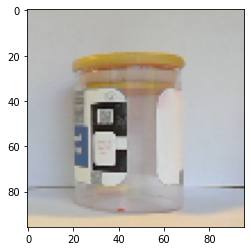

INSUFFICIENT


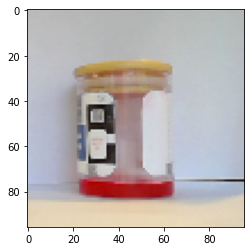

INSUFFICIENT


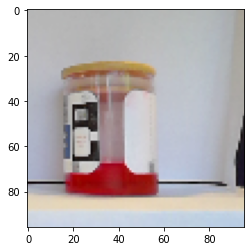

SUFFICIENT


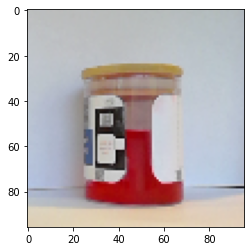

INSUFFICIENT


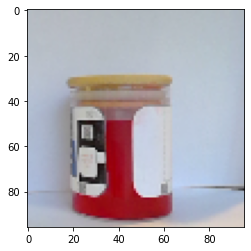

SUFFICIENT


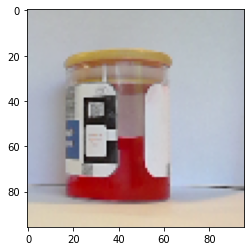

SUFFICIENT


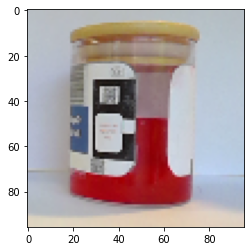

INSUFFICIENT


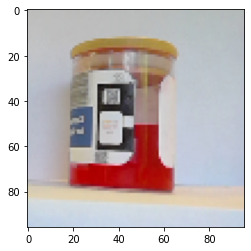

SUFFICIENT


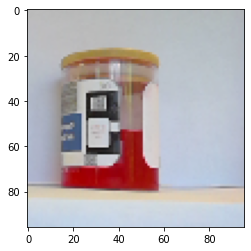

SUFFICIENT


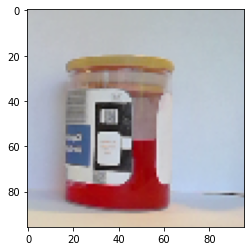

SUFFICIENT


In [18]:
# Prediction of class using test data set

i = 0

test_images_loc = './data/images_test/'

for image_path in glob('./data/images_test/*.*'):
    test_1 = preprocessing.image.load_img(test_images_loc + str(i) + '.png',
                                          target_size = (width, height))
    
    plt.imshow(test_1)
    plt.show()
    
    test_1_X = np.expand_dims(test_1, axis = 0)
    predictions = model.predict(test_1_X)

    print(class_names[np.argmax(predictions)])
    
    i += 1